In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from _funcs import *

plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({'font.size': 24})

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

# Computing diffusion figures

In this notebook, we will generate the figures for the diffusion model to study the FPT. The model we will consider is the following 
$$
H = \Omega \sigma_{x}\quad L_{K} = \sqrt{\Gamma} \sigma_{-}
$$
and then we will perform Homodyne detection along \sigma_{y} which can be achieved using the measurement superoperat
$$
L_{k} \rightarrow = i L_{k}
$$

In [15]:
# ------ Parameters ------ #
# Parameters 
Gamma = 0.5
Omega = 1

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sy = sigmay()
sz = sigmaz()
H = (Omega/2)*sx

# define dissipator and Hamiltonian
L = 1j*np.sqrt(Gamma) * sm
c_ops = [L]    

# number of chargers to truncate at 
Nm = 20
dN = 0.05
N_cutoff = 2
N = np.arange(-Nm, Nm, dN)

# Define initial state
rhoss = steadystate(H, c_ops)
rho0 = fock_dm(2, 1)
rho1 = fock_dm(2, 0)

# define time parameters
dt = 0.002
t = np.arange(0, 15, dt)


In [16]:
# ------ Solve n-resolved method with absorbing boundary conditions ------ #
diff = DiffusiveEvolutionPntAbsorb(H, [L], 1, t, N, N_cutoff, kind='single')
Pn_vec = diff.solve(rho0)

Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 7499/7499 [00:29<00:00, 256.41it/s]


In [17]:
# ------ Solve using Monte Carlo method ------ #
ntraj = 2000
results = smesolve(H, rho0, t, sc_ops=c_ops, e_ops=[fock_dm(2,0)], ntraj=ntraj, store_measurement=True)

10.0%. Run time:   8.91s. Est. time left: 00:00:01:20
20.0%. Run time:  17.78s. Est. time left: 00:00:01:11
30.0%. Run time:  26.62s. Est. time left: 00:00:01:02
40.0%. Run time:  35.47s. Est. time left: 00:00:00:53
50.0%. Run time:  44.31s. Est. time left: 00:00:00:44
60.0%. Run time:  53.18s. Est. time left: 00:00:00:35
70.0%. Run time:  62.00s. Est. time left: 00:00:00:26
80.0%. Run time:  70.73s. Est. time left: 00:00:00:17
90.0%. Run time:  79.45s. Est. time left: 00:00:00:08
Total run time:  88.18s


In [18]:
# Get Homodyne signal
homodyne =  np.real(np.array(results.measurement)).astype('float32').T[0]
homodyne_integrate = np.cumsum(homodyne, axis=0)*dt

In [19]:
# Get unconditional results
result = mesolve(H, rho0, t, c_ops=c_ops, e_ops=[sy])
sye = result.expect[0]
sye_int = np.sqrt(Gamma)*np.cumsum(sye, axis=0)*dt

In [20]:
# Get hitting times of homodyne dynamics
inds_homodyne = np.array([get_first_hit(mi, N_cutoff) for mi in homodyne_integrate.T])
inds_homodyne = inds_homodyne[inds_homodyne != None]

# Get first hitting times for homodyne
hitting_times_homodyne = t[list(inds_homodyne)]
mean_hitting_time_homodyne_sim = np.mean(hitting_times_homodyne)

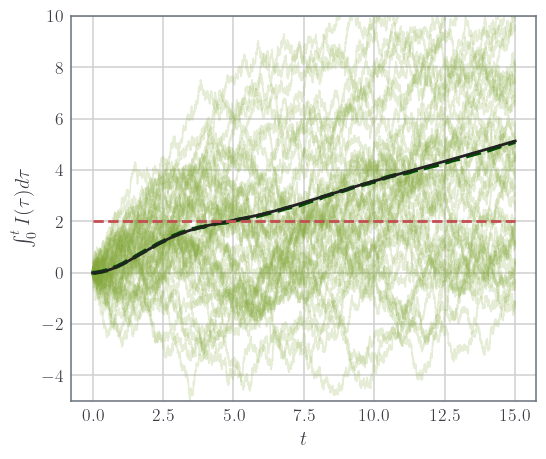

In [35]:
# Plot integrate measurements
fig = plt.figure(figsize=(6, 5))
plt.plot(t, homodyne_integrate[:, :50], color='g', alpha=0.2)
plt.plot(t, np.mean(homodyne_integrate, axis=1), 
         color=[0,0.3,0], 
         linewidth=3,
         linestyle='--',
         label=r'$\langle \sigma_{y} \rangle_{H}$'
         )

plt.plot(t, sye_int,
            color='k',
            linewidth=2,
            linestyle='-',
            label=r'$\langle \sigma_{y} \rangle_{MC}$'
            )

plt.hlines(N_cutoff, 0, 15, color='r', linewidth=2, linestyle='--')

plt.xlabel(r'$t$')
plt.ylabel(r'$ \int_{0}^{t} I(\tau)d\tau $')
plt.ylim(-5, 10)

plt.show()

In [22]:
# Get first hitting indices    
inds = np.array([get_first_hit(mi, N_cutoff) for mi in homodyne_integrate.T])
inds = inds[inds != None]

# Get first hitting times
hitting_times = t[list(inds)]

In [36]:

# Compute survival probability from analytic solution
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)
norm = np.sum(dGt)*dt

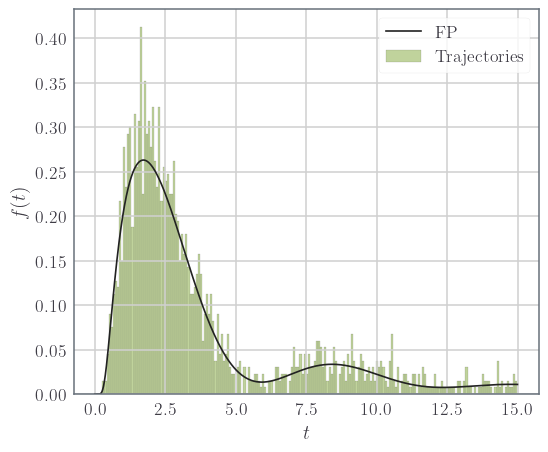

In [37]:
fig = plt.figure(figsize=(6, 5))
plt.plot(t, dGt, color='k', label=r'$\mathrm{FP}$')
plt.hist(hitting_times, density=True, bins=200, color='g', alpha=0.5, edgecolor='k', label=r'$\mathrm{Trajectories}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$f(t)$')
plt.legend()
plt.show()